## Environment Setup

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Data Understanding and Preprocessing

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "fashion_mnist",
    split=["train","test"],
    shuffle_files= True, # Shuffle to avoid original dataset is using a special sequence 
    as_supervised=True, # Included Image and Label of the dataset
    with_info=True, # 'True': Able to print 'ds_info' to show dataset information
)

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

In [ ]:
# Normalize image into (0,1) for model training
def normalize_img(image, label):
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

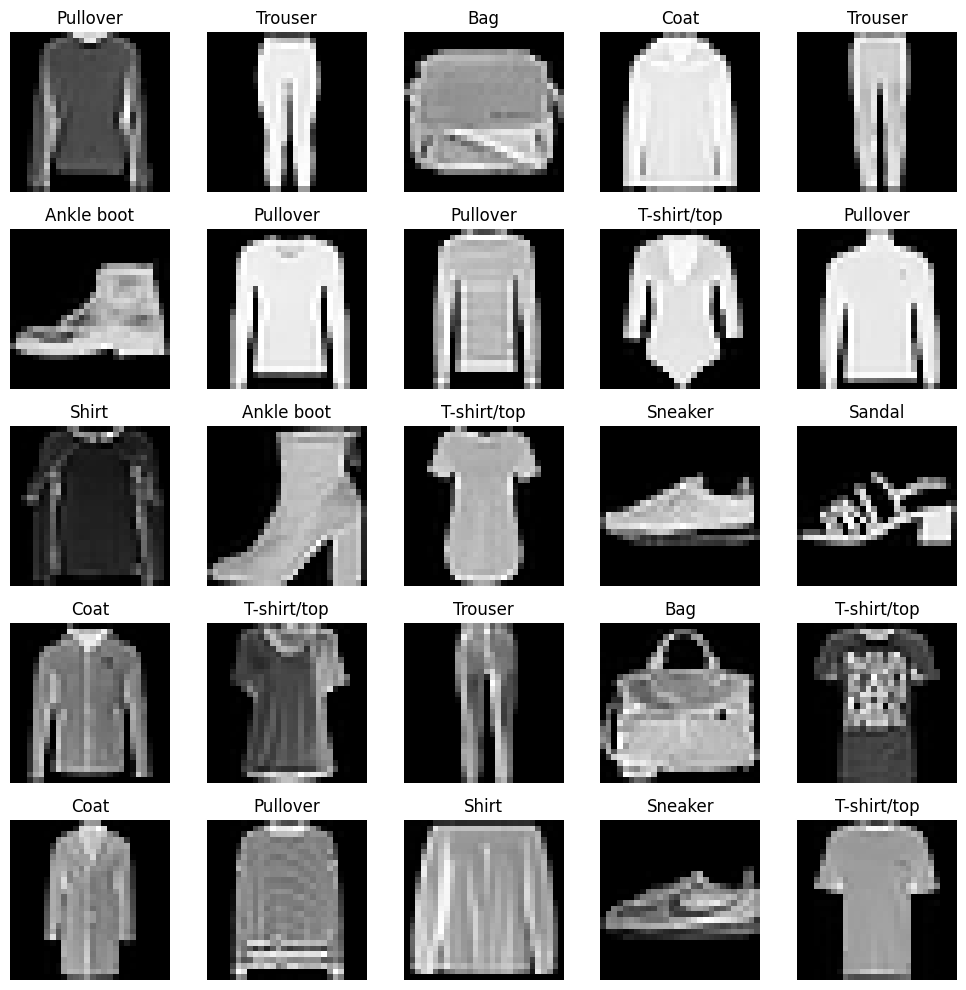

In [ ]:
# Visualization for the training images with labels

def extract_images_labels(dataset, num_samples):
    images = []
    labels = []
    for image, label in dataset.take(num_samples):
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

x_train_samples, y_train_samples = extract_images_labels(ds_train, 25)

def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        plt.title(f'{class_names[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plot_images(x_train_samples, y_train_samples)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32


ds_train = ds_train.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)


In [ ]:
ds_test = ds_test.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

# Model Building

In [ ]:
class CustomConv2D(layers.Layer):
    def __init__(self, filters, kernel_size):
        super(CustomConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size

    # Define kernel as the neurons in this CNN layer wiht a 'he_normal' initializer
    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, self.kernel_size, input_channels, self.filters),
            initializer='he_normal',
            trainable=True,
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.filters,),
            initializer='zeros',
            trainable=True,
        )

    # Define layer flow
    def call(self, inputs):
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        conv_output = tf.nn.bias_add(conv_output, self.bias)
        return conv_output


In [ ]:
# Define CNN Model with 3 convolution layers with different filter size.
class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = CustomConv2D(filters=32, kernel_size=3)
        self.conv2 = CustomConv2D(filters=64, kernel_size=3)
        self.conv3 = CustomConv2D(filters=128, kernel_size=3)
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64)
        self.dense = layers.Dense(10)
    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = tf.nn.relu(x)
        x = self.dense(x)
        return x

    def model(self):
        x = keras.Input(shape = (28,28,1))
        return keras.Model(inputs = [x], outputs = self.call(x))

In [ ]:
# Define custom fit 
class CustomFit(keras.Model):
    def __init__(self,model):
        super(CustomFit,self).__init__()
        self.model = model

    def compile(self, optimizer, loss):
        super(CustomFit, self).compile()
        self.optimizer = optimizer
        self.loss = loss

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self.model(x, training = True)
            loss = self.loss(y, y_pred)
        
        # Manually computes gradients using tf.GradientTape    
        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        # Manually applies gradients to the optimizer
        self.optimizer.apply_gradients(zip(gradients, training_vars))
        # Custom accuracy metric update, manually handled
        acc_metric.update_state(y,y_pred)


        return {"loss" : loss, "accuracy":acc_metric.result()}

    def test_step(self,data):
        x, y = data

        y_pred = self.model(x, training = False)
        # Manually calculates loss
        loss= self.loss(y,y_pred)
        # Custom accuracy metric update, manually handled
        acc_metric.update_state(y ,y_pred)

        return {"loss" : loss, "accuracy":acc_metric.result()}
        # Returns a dictionary of loss and accuracy

# Custom accuracy metric used for both training and testing steps
acc_metric = keras.metrics.SparseCategoricalAccuracy(name = "accuracy")

In [ ]:
# Gradually decreases the learning rate during training with an exponential pattern.
# Happens in discrete steps, making the learning rate drop suddenly at each interval.

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
callbacks = [
    #  Stops training early if the validation loss doesn't improve by at least 
    #  0.01 (min_delta) after 2 epochs (patience), prevent overfitting.
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1,
    ),
    # If the validation loss doesn't improve after 2 epochs, allowing finer adjustments during training.
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1
    ),
]

# Model Training

In [ ]:
model = CNNModel()

In [ ]:
training = CustomFit(model)

In [ ]:
training.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
)

In [ ]:
training.fit(ds_train, batch_size = 32, epochs = 10, verbose = 2, callbacks = callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'cnn_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1875/1875 - 180s - 96ms/step - accuracy: 0.8766 - loss: 0.2074 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1875/1875 - 189s - 101ms/step - accuracy: 0.8993 - loss: 0.2366 - learning_rate: 0.0010
Epoch 3/10
1875/1875 - 203s - 108ms/step - accuracy: 0.9137 - loss: 0.2025 - learning_rate: 0.0010
Epoch 4/10
1875/1875 - 201s - 107ms/step - accuracy: 0.9246 - loss: 0.0679 - learning_rate: 0.0010
Epoch 5/10
1875/1875 - 162s - 87ms/step - accuracy: 0.9334 - loss: 0.0256 - learning_rate: 0.0010
Epoch 6/10
1875/1875 - 203s - 108ms/step - accuracy: 0.9408 - loss: 0.2691 - learning_rate: 0.0010
Epoch 7/10
1875/1875 - 161s - 86ms/step - accuracy: 0.9469 - loss: 0.0105 - learning_rate: 0.0010
Epoch 8/10
1875/1875 - 163s - 87ms/step - accuracy: 0.9520 - loss: 0.0191 - learning_rate: 0.0010
Epoch 9/10
1875/1875 - 162s - 87ms/step - accuracy: 0.9562 - loss: 0.0088 - learning_rate: 0.0010
Epoch 10/10
1875/1875 - 202s - 108ms/step - accuracy: 0.9596 - loss: 0.0120 - learning_rate: 0.0010


In [ ]:
training.evaluate(ds_train, batch_size = 32)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.9612 - loss: 0.0167


[0.013517376035451889, 0.9627439379692078]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


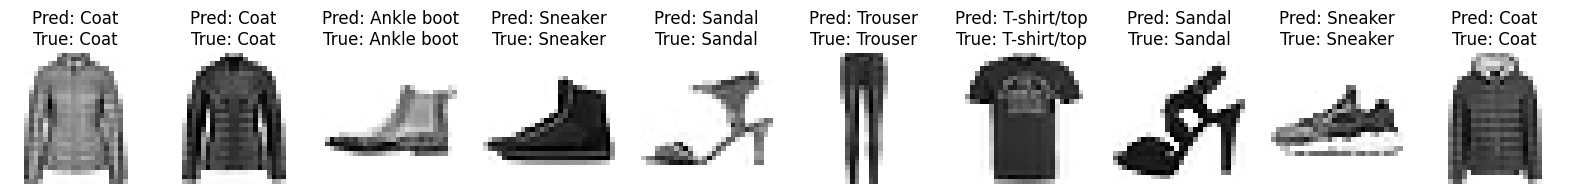

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(model, data, labels, class_names, num_images=10):
    predictions = model.predict(data)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(data[i], cmap=plt.cm.binary)
        plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')

    plt.show()

for batch in ds_test.take(1):
    test_images, test_labels = batch

test_images = np.array(test_images)
test_labels = np.array(test_labels)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_predictions(model, test_images, test_labels, class_names)